<h1><center><strong> X-Ray Body Parts Prediction </center></strong></h1> 

Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-08-08 11:02:07.878163: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 11:02:07.879659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 11:02:07.914026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 11:02:07.914798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 11:02:08.609005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Data Cleaning

In [2]:
# load train_df and test_df csv into a dataframe
train_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train_df.csv'))
test_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'test_df.csv'))

In [3]:
# strip() whitespaces from start and end of the string
# split() string into a list using emptyspace ' ' as a delimiter 
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip(' '))
train_df['Target'] = train_df['Target'].apply(lambda x: x.split(' '))
for i, val in enumerate(train_df['Target']):
    print(i,val)

0 ['0']
1 ['15']
2 ['12']
3 ['14']
4 ['3']
5 ['3']
6 ['14']
7 ['13', '20']
8 ['3']
9 ['3']
10 ['3']
11 ['14']
12 ['3']
13 ['3']
14 ['5']
15 ['14']
16 ['3']
17 ['0']
18 ['17']
19 ['2']
20 ['3']
21 ['3']
22 ['6']
23 ['9', '21']
24 ['3']
25 ['0']
26 ['3']
27 ['14']
28 ['3']
29 ['3']
30 ['9']
31 ['16']
32 ['6']
33 ['7']
34 ['3']
35 ['3']
36 ['11']
37 ['3']
38 ['14']
39 ['3']
40 ['3']
41 ['11']
42 ['1']
43 ['15']
44 ['2']
45 ['3']
46 ['2']
47 ['1']
48 ['20']
49 ['14']
50 ['0']
51 ['3']
52 ['21']
53 ['3']
54 ['14']
55 ['17']
56 ['14']
57 ['3']
58 ['16']
59 ['3']
60 ['3']
61 ['17']
62 ['3']
63 ['3']
64 ['3']
65 ['3']
66 ['1']
67 ['6']
68 ['13']
69 ['3']
70 ['3']
71 ['13', '20']
72 ['16']
73 ['3']
74 ['13', '20']
75 ['0', '3']
76 ['3']
77 ['3']
78 ['3']
79 ['3']
80 ['8']
81 ['3']
82 ['6']
83 ['5']
84 ['3']
85 ['14']
86 ['2']
87 ['15']
88 ['3']
89 ['21']
90 ['3']
91 ['3']
92 ['0']
93 ['3']
94 ['3']
95 ['13', '20']
96 ['3']
97 ['3']
98 ['11']
99 ['13']
100 ['2']
101 ['1', '11', '12']
102 ['13', 

In [4]:
train_path = os.path.join(os.getcwd(), 'data', 'images', 'train')

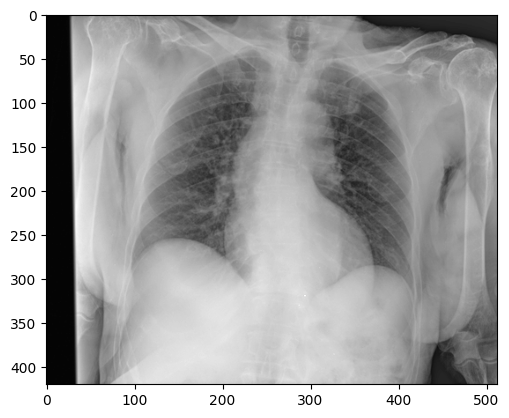

In [5]:
# displaying a sample image index 7 in df row
image_name = train_df.loc[7].SOPInstanceUID + '-c.png'
image = plt.imread(os.path.join(train_path, image_name))
plt.imshow(image, cmap='gray')

In [6]:
# identify multi label images so they can be used while training with respect to their labels
multi_label_images = []
for i, val in enumerate(train_df.Target):
    if len(val) > 1:
        multi_label_images.append((os.path.join(train_path, train_df.loc[i].SOPInstanceUID + '-c.png'), train_df.loc[i].Target))

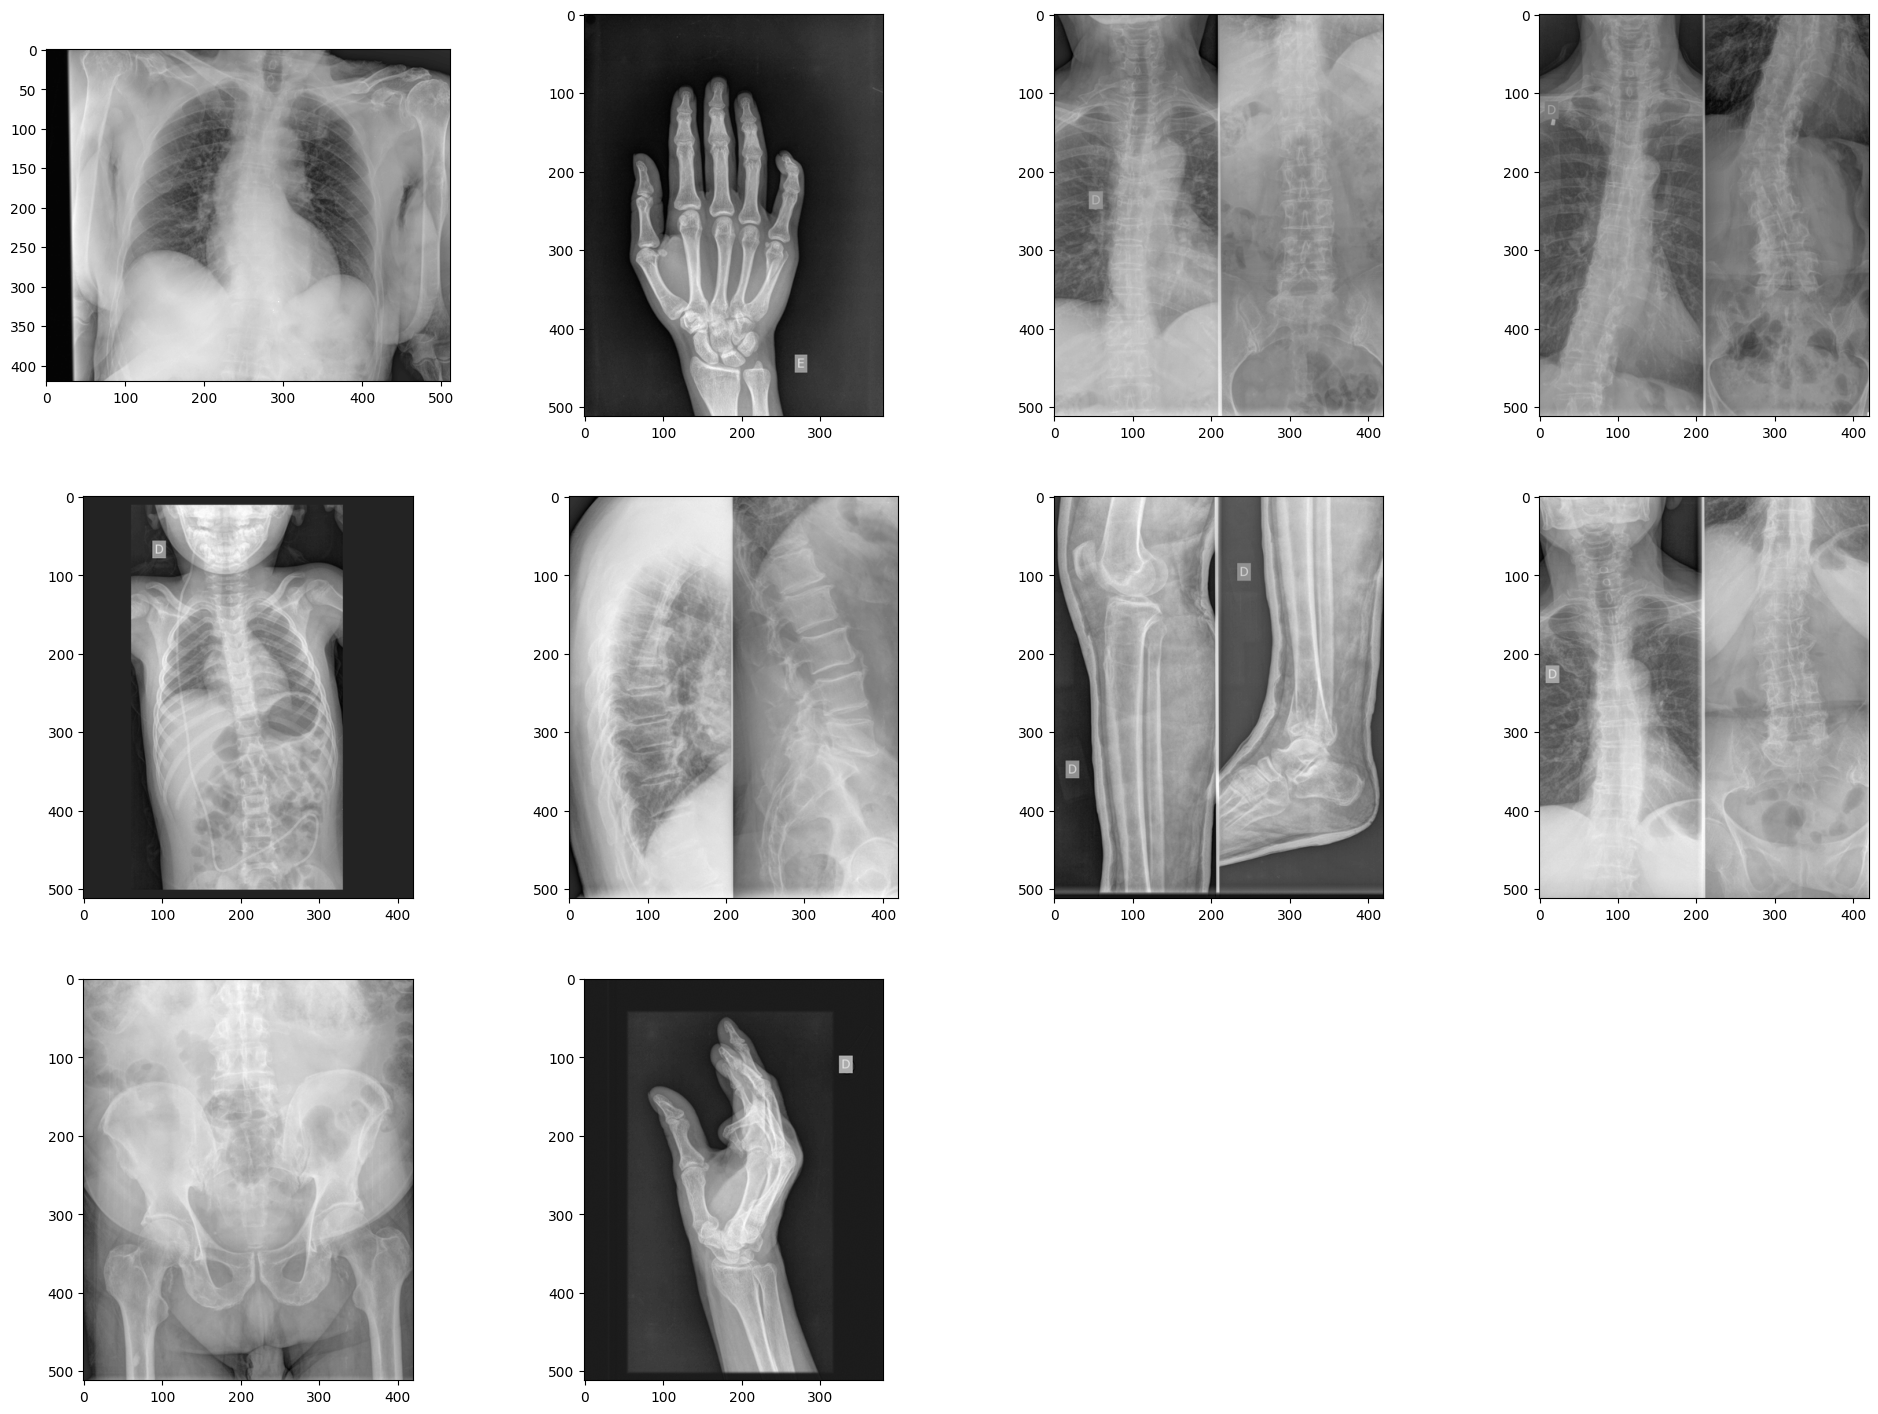

In [7]:
# iterate over multi_label_images and subplot images that contain multi labels
plt.figure(figsize=(24, 24))
for i in range(10):
    plt.subplot(4,4,i+1)
    img = plt.imread(multi_label_images[i][0])
    plt.imshow(img, cmap='gray')


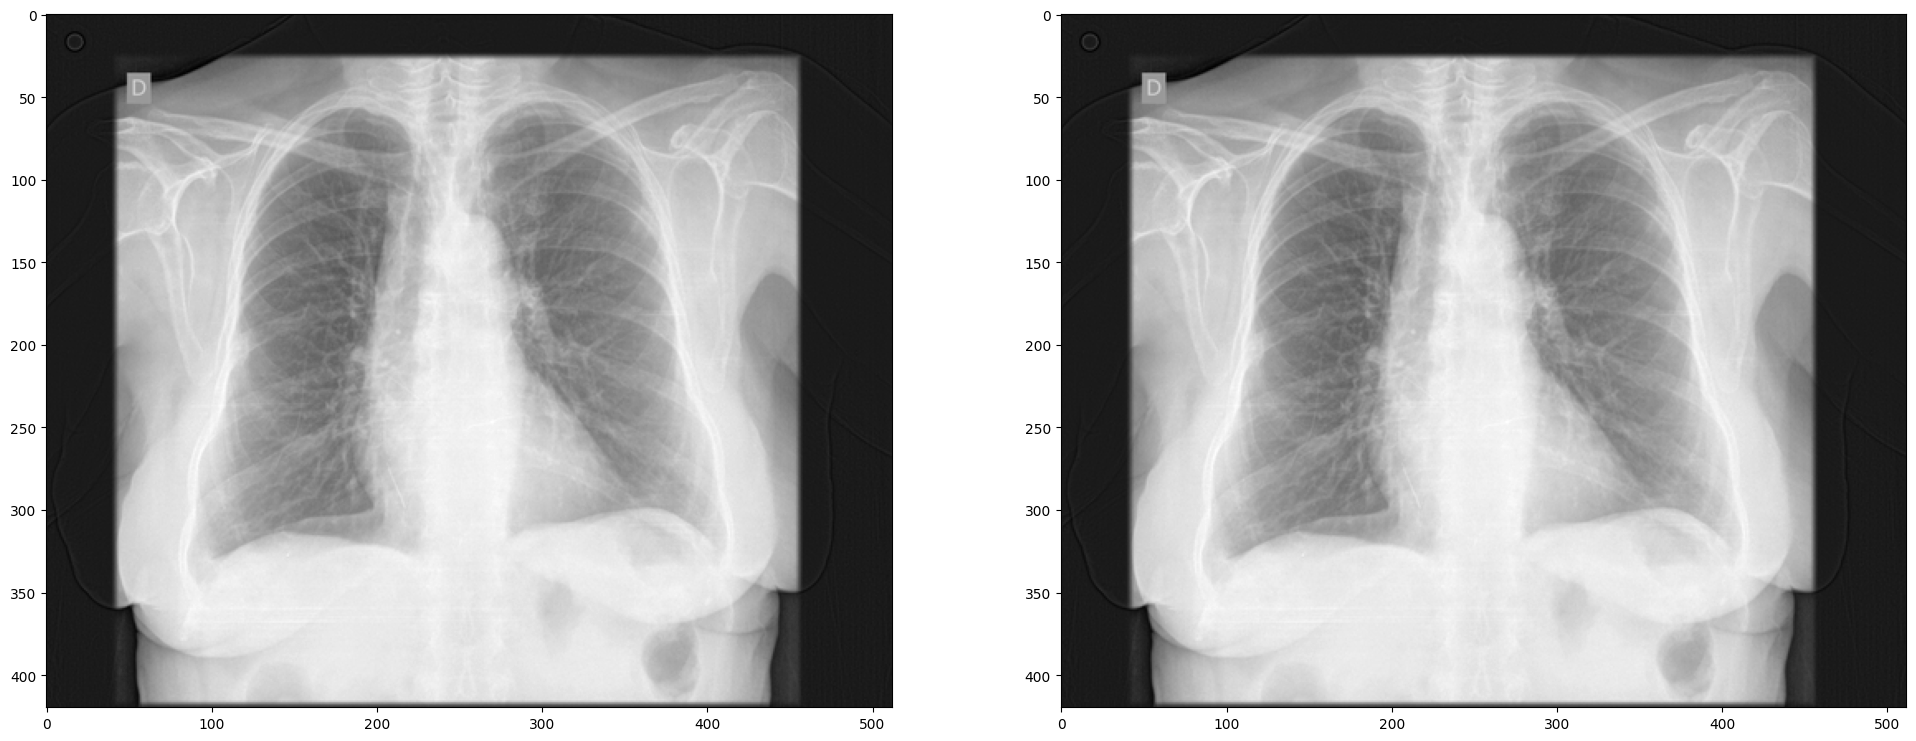

In [8]:
# compare original with normalized image 
plt.figure(figsize=(24,24))
img = plt.imread(os.path.join(os.getcwd(), 'data', 'image_png.png'))
'''
cv2.normalize() process modifies the intensity values of pixels in a given image to make the image more appealing. It can be used for 
- Contrast Enhancement using norm_tye=cv2.cv2.NORM_MINMAX
- Machine Learning for scaling the pixel values between 0 to 1 to help neural network to converge faster
- Comparison and Visualization can make it easier to compare images and identify patterns or anomalies
- Preprocessing for Algorithms for edge detection allows algorithim to detect eges consistently across different images
The scaled image might look similar to the original image, but with adjusted brightness and contrast based on the chosen normalization method (alpha, beta, and norm_type). For example, a grayscale image that appears too dark might be scaled to increase the brightness, making the image more visible.

Formula: 
dst = (src - min(src)) * (beta - alpha) / (max(src) - min(src)) + alpha

dst: This represents the output array where the normalized pixel values will be stored.
src: This is the input array, which contains the original pixel values of the image that you want to normalize.
min(src): This is the minimum value of the src array, i.e., the minimum pixel value in the image.
max(src): This is the maximum value of the src array, i.e., the maximum pixel value in the image.
alpha: This is the offset parameter, and it determines the value that will be added to the normalized pixel values after scaling.
beta: This is the scaling parameter, and it determines the value that will be multiplied with the normalized pixel values after subtracting min(src).

Alpha (off-set) (lower-bound): 
This is the offset parameter, and it determines the value that will be added to the normalized pixel values after scaling. It is often used to set the lower bound of the output range. If alpha is set to 0, it means there is no offset, and the normalized values will start from 0. Increasing alpha will shift the normalized values upwards.

Beta (Scaling) (upper-bound): 
This is the scaling parameter, and it determines the value that will be multiplied with the normalized pixel values after subtracting min(src). It is often used to set the upper bound of the output range. If beta is set to 1, it means there is no scaling, and the normalized values will remain within the range determined by alpha. Increasing beta will stretch the normalized values.

norm_type:
cv2.NORM_MINMAX: This method scales and shifts the pixel values to the specified range [alpha, beta]. The formula for normalization is dst = (src - min(src)) * (beta - alpha) / (max(src) - min(src)) + alpha, where src is the input array.
'''
norm_img = cv2.normalize(img, None, alpha=0, beta=500, norm_type=cv2.NORM_MINMAX)
plt.subplot(2, 2, 1)
plt.imshow(norm_img, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(img, cmap='gray')

In [9]:
# create a df 'train_dff' and extract required series
train_dff = pd.DataFrame()
train_dff['SOPInstanceUID'] = train_df['SOPInstanceUID']
train_dff['Target'] = train_df['Target']
train_dff.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0]
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15]
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12]
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14]
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3]
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,[3]
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,[14]
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,"[13, 20]"
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,[3]
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,[3]


In [10]:
def labels(label):
    if label == 0:
        return 'Abdomen'
    elif label == 1:
        return 'Ankle'
    elif label == 2:
        return 'Cervical Spine'
    elif label == 3:
        return 'Chest'
    elif label == 4:
        return 'Clavicles'
    elif label == 5:
        return 'Elbow'
    elif label == 6:
        return 'Feet'
    elif label == 7:
        return 'Finger'
    elif label == 8:
        return 'Forearm'
    elif label == 9:
        return 'Hand'
    elif label == 10:
        return 'Hip'
    elif label == 11:
        return 'Knee'
    elif label == 12:
        return 'Lower Leg'
    elif label == 13:
        return 'Lumbar Spine'
    elif label == 14:
        return 'Others'
    elif label == 15:
        return 'Pelvis'
    elif label == 16:
        return 'Shoulder'
    elif label == 17:
        return 'Sinus'
    elif label == 18:
        return 'Skull'
    elif label == 19:
        return 'Thigh'
    elif label == 20:
        return 'Thoracic Spine'
    elif label == 21:
        return 'Wrist'


In [11]:
train_dff['Target'].head(15)

0          [0]
1         [15]
2         [12]
3         [14]
4          [3]
5          [3]
6         [14]
7     [13, 20]
8          [3]
9          [3]
10         [3]
11        [14]
12         [3]
13         [3]
14         [5]
Name: Target, dtype: object

In [12]:
# creating a new series 'Labels' with str representation of labels
train_dff['Labels'] = train_dff['Target'].apply(lambda x: ' '.join([labels(int(l)) for l in x]))

In [13]:
train_dff.head(10)

,SOPInstanceUID,Target,Labels
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0],Abdomen
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15],Pelvis
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12],Lower Leg
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14],Others
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3],Chest
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,[3],Chest
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,[14],Others
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,"[13, 20]",Lumbar Spine Thoracic Spine
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,[3],Chest
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,[3],Chest


In [14]:
train_dff = pd.get_dummies(train_dff['Labels'])

In [15]:
train_dff.head(10)
train_dff['SOPInstanceUID'] = train_df['SOPInstanceUID']
train_dff['Target'] = train_df['Target']
train_dff.head(3)

,Abdomen,Abdomen Chest,Abdomen Pelvis,Ankle,Ankle Feet,Ankle Knee Lower Leg,Ankle Lower Leg,Cervical Spine,Cervical Spine Lumbar Spine Thoracic Spine,Cervical Spine Thoracic Spine,...,Pelvis,Pelvis Thigh,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist,SOPInstanceUID,Target
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0]
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15]
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12]


In [16]:
new_train_df = pd.merge(train_df, train_dff, on='SOPInstanceUID')
new_train_df.head()

,SOPInstanceUID,Target_x,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,StudyDate,SeriesDate,...,Others,Pelvis,Pelvis Thigh,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist,Target_y
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[0]
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,True,False,False,False,False,False,False,False,[15]
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[12]
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14],NaN,NaN,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,True,False,False,False,False,False,False,False,False,[14]
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[3]


In [17]:
new_train_df.drop('Target_y', axis=1, inplace=True)

In [18]:
new_train_df.columns[65:]

Index(['Abdomen', 'Abdomen Chest', 'Abdomen Pelvis', 'Ankle', 'Ankle Feet',
       'Ankle Knee Lower Leg', 'Ankle Lower Leg', 'Cervical Spine',
       'Cervical Spine Lumbar Spine Thoracic Spine',
       'Cervical Spine Thoracic Spine', 'Chest', 'Chest Feet', 'Chest Finger',
       'Chest Pelvis', 'Clavicles', 'Elbow', 'Elbow Forearm', 'Feet', 'Finger',
       'Finger Hand', 'Forearm', 'Forearm Shoulder', 'Hand', 'Hand Wrist',
       'Hip', 'Hip Knee Thigh', 'Hip Thigh', 'Knee', 'Knee Lower Leg',
       'Lower Leg', 'Lumbar Spine', 'Lumbar Spine Thoracic Spine', 'Others',
       'Pelvis', 'Pelvis Thigh', 'Shoulder', 'Sinus', 'Skull', 'Thigh',
       'Thoracic Spine', 'Wrist'],
      dtype='object')

Images have different sizes we need to standardize them to (128, 128) pixels for this we will use cv2.resize()

In [19]:
X = []
Y = []

In [20]:

for i, val in enumerate(new_train_df.SOPInstanceUID):
    SOPInstance = val
    image_path = os.path.join(train_path, val + '-c.png')
    img = cv2.imread(image_path)
    img_resize = cv2.resize(img, dsize=(128, 128))
    img_norm = cv2.normalize(img_resize, None, alpha=0, beta=500, norm_type=cv2.NORM_MINMAX)
    # var 'X' will contain the array representation of orginal image and we add a new dimention to the array at start
    X.append(np.expand_dims(img_resize, axis=-1))
    # flatten img_norm into 1d array and store it in list var 'Y'
    Y.append(np.ndarray.flatten(np.array(new_train_df.loc[i][new_train_df.columns[65:]])))

X = np.array(X)
Y = np.array(Y)

In [ ]:
X